In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo
import corner

import pymc3 as pm
import theano.tensor as tt

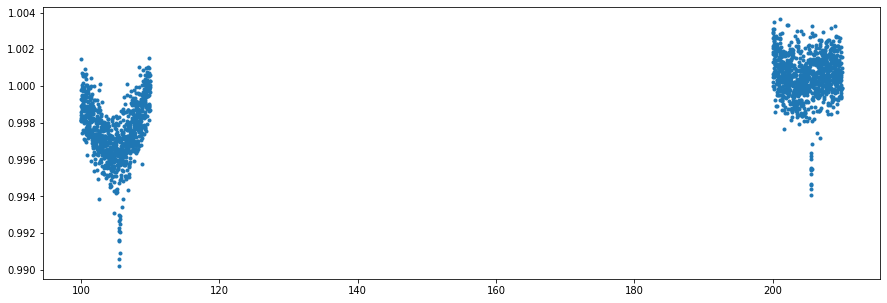

In [17]:
x = np.concatenate((np.arange(100,110,0.01), np.arange(200,210,0.01)))

#Adding some randomised sinusoids to mimic stellar variability:
y_sv=abs(np.random.normal(0.002,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(5,1)))+abs(np.random.normal(0.001,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(3,0.8)))

y = np.concatenate((np.random.normal(1.0,0.001,1000), np.random.normal(1.0,0.001,1000)))+y_sv
yerr = 0.001 + np.zeros_like(y)

t0s=[105.57, 205.57]

true_orbit = xo.orbits.KeplerianOrbit(period=20.0, t0=t0s[0], b=0.3, omega=0.72, ecc=0.5)
true_model = xo.LimbDarkLightCurve([0.3, 0.2]).get_light_curve(orbit=true_orbit, t=x, r=np.sqrt(0.0045))[:, 0].eval()
y += true_model

plt.figure(figsize=(15,5))
plt.plot(x, y,'.');

In [18]:
#Here we compute the max period and the min period
dur=0.24
max_P=t0s[1]-t0s[0]

#Folding x on maximum period with the first transit at 0.0
folded_x=np.sort(abs((x-t0s[0]-max_P*0.5)%max_P-max_P*0.5))

#minimum P is the first instance of a gap bigger than the duration in absolute phase space:
min_P=np.where(np.diff(folded_x)>dur)[0]
min_P=min_P[0] if len(min_P)>1 else min_P
min_P=np.max(folded_x) if len(min_P)==0 else min_P
period_index = np.arange(1, max_P/min_P, 1)

# Simple model:

(i.e. circular)

In [19]:
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=1.0)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=1.0)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.01, upper=0.1,  testval=np.sqrt(0.00325))
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1) / period_index)
    
    logprobs = []
    logpriors = []
    all_lcs = []
    for i, index in enumerate(period_index):
        with pm.Model(name="per_{0}".format(i), model=model) as submodel:
            
            period = periods[i]
            
            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0_1, b=b)
        
            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            light_curve = pm.Deterministic("light_curve", pm.math.sum(light_curves, axis=-1) + mean)  
            all_lcs.append(light_curve)
            
            # Compute the log prob
            loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            logprior = -8 * tt.log(period) / 3
            logprobs.append(loglike + logprior)
            
            #Adding way to keep track of prior probability and lightcurve
            logpriors.append(logprior)

    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
        
    print(model.check_test_point())
    map_soln = xo.optimize(vars=[mean, u, r, b])
    map_soln = xo.optimize(map_soln)

/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


mean               -0.92
t0_1               -0.92
t0_2               -0.92
u_quadlimbdark__   -3.23
r_interval__       -1.39
b_impact__         -1.44
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [b, r, u, mean]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
31it [00:00, 191.17it/s, logp=8.252051e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
43it [00:00, 186.04it/s, logp=8.252051e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Usi

In [20]:
map_soln

{'mean': array(0.99912379),
 't0_1': array(105.56935497),
 't0_2': array(205.56727019),
 'u_quadlimbdark__': array([-1.43894133, -0.57469631]),
 'r_interval__': array(0.81365907),
 'b_impact__': array(-0.82806178),
 'u': array([0.31538406, 0.1224622 ]),
 'r': array(0.07235998),
 'b': array(0.32605647),
 'periods': array([99.99791521, 49.99895761, 33.3326384 , 24.9994788 , 19.99958304,
        16.6663192 , 14.28541646, 12.4997394 , 11.11087947,  9.99979152,
         9.09071956,  8.3331596 ,  7.69214732,  7.14270823,  6.66652768,
         6.2498697 ,  5.88223031]),
 'per_0_light_curve': array([0.99912379, 0.99912379, 0.99912379, ..., 0.99912379, 0.99912379,
        0.99912379]),
 'per_1_light_curve': array([0.99912379, 0.99912379, 0.99912379, ..., 0.99912379, 0.99912379,
        0.99912379]),
 'per_2_light_curve': array([0.99912379, 0.99912379, 0.99912379, ..., 0.99912379, 0.99912379,
        0.99912379]),
 'per_3_light_curve': array([0.99912379, 0.99912379, 0.99912379, ..., 0.99912379, 

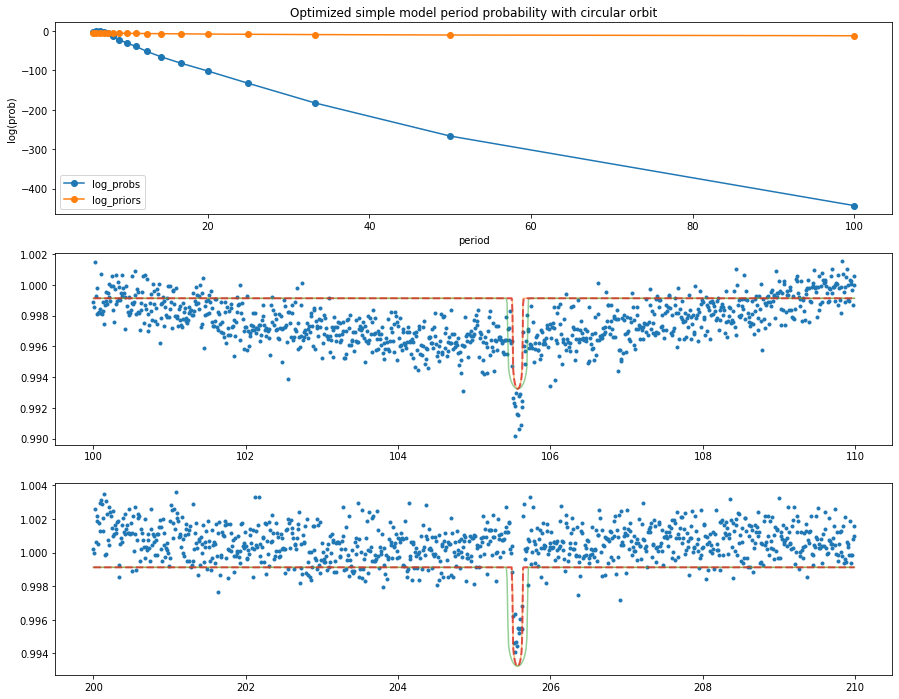

In [21]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln["periods"], map_soln["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized simple model period probability with circular orbit")
plt.plot(map_soln["periods"],map_soln["logprior_class"],'-o',label='log_priors')
#[map_soln['per_'+str(n)+'_log_prior'] for n in range(17)],'-o',label='log_priors')
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln["per_16_light_curve"][:1000],alpha=0.5)
plt.plot(x[:1000],map_soln["per_1_light_curve"][:1000],alpha=0.5)
plt.plot(x[:1000],map_soln["marginalized_light_curve"][:1000],'--',alpha=0.75,linewidth=2.0)

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln["per_16_light_curve"][1000:],alpha=0.5)
plt.plot(x[1000:],map_soln["per_1_light_curve"][1000:],alpha=0.5)
plt.plot(x[1000:],map_soln["marginalized_light_curve"][1000:],'--',alpha=0.75,linewidth=2.0)

Clear preference for the correct model here. That's good to see.

# Adding GPs & stellar info. Maintaining circular orbit:

In [22]:
with pm.Model() as model_gp_circ:

    #Baseline flux is now in the GPs, so deleting this:
    #mean = pm.Normal("mean", mu=1.0, sd=1.0)

    Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
    logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
    rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))
             
    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=0.4)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=0.4)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.001, upper=0.3)
    ror=pm.Deterministic("ror", r/Rs)
    b = xo.distributions.ImpactParameter("b", ror=ror, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1)/period_index)
    
    #Jitter term. Initialised with the std of y
    logs2 = pm.Normal("logs2", mu=np.log(np.std(y)),sd=1.0,testval=np.log(np.std(y)))
    
    #Guess P_var=10d to begin:
    logw0_guess = np.log(2*np.pi/10)

    #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
    min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
    lcrange=x[-1]-x[0]
    logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                       upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
    logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Initialising GP model for the light curve
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)
    
    logprobs = []
    logpriors= []
    all_lcs = []
    gp_preds = []
    for i, index in enumerate(period_index):

        with pm.Model(name="per_{0}".format(i), model=model_gp_circ) as submodel:
            
            period = periods[i]
            
            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(
                    period=period, t0=t0_1, b=b)
            
            #Adding deterministic tdur
            vx, vy, vz = orbit.get_relative_velocity(t0_1) #To calculate Tdur
            vrel=pm.Deterministic("vrel",tt.sqrt(vx**2 + vy**2)/Rs)
            tdur=pm.Deterministic("tdur",(2*tt.sqrt(1-b**2))/vrel)

            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            lc=pm.math.sum(light_curves, axis=-1)
            light_curve = pm.Deterministic("light_curve",lc) 
            
            # Compute the log prob
            #loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            loglike = tt.sum(gp.log_likelihood(y - light_curve))
            gp_pred = pm.Deterministic("gp_pred", gp.predict())
            gp_preds.append(gp.predict())
            
            all_lcs.append(lc)

            #Computing log prior.
            #Here we'll use P^-8/3 (occurrence rate (P^-1) * window function (P^-1) * transit probability (P^-2/3) )
            logprior = -8 * tt.log(period) / 3
            logprobs.append(loglike + logprior)
            logpriors.append(logprior)

    
    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    
    gp_preds_all = tt.stack(gp_preds)
    
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve and gp prediction
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
    pm.Deterministic("marginalized_gp_pred", tt.sum(tt.stack(gp_preds) * tt.exp(logprob_class)[:, None], axis=0))
    
    #Optimising:
    print(model_gp_circ.test_point)
    print(model_gp_circ.check_test_point())
    map_soln_gp_circ = xo.optimize(vars=[r, b])
    map_soln_gp_circ = xo.optimize(start=map_soln_gp_circ, vars=[logs2])
    map_soln_gp_circ = xo.optimize(start=map_soln_gp_circ, vars=[t0_1, t0_2])
    map_soln_gp_circ = xo.optimize(start=map_soln_gp_circ, vars=[logs2, logpower])
    map_soln_gp_circ = xo.optimize(start=map_soln_gp_circ, vars=[logw0])
    map_soln_gp_circ = xo.optimize(start=map_soln_gp_circ, vars=[r,b,Rs,u])

    map_soln_gp_circ = xo.optimize(map_soln_gp_circ)
    

/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


{'Rs': array(1.), 'logrho_S': array(0.), 't0_1': array(105.57), 't0_2': array(205.57), 'u_quadlimbdark__': array([-1.09861229, -0.84729786]), 'r_interval__': array(0.), 'b_impact__': array(-0.59116847), 'logs2': array(-6.20283651), 'logw0_interval__': array(-0.60183699), 'logpower_interval__': array(1.20816619)}
Rs                     0.29
logrho_S              -0.23
t0_1                  -0.00
t0_2                  -0.00
u_quadlimbdark__      -3.23
r_interval__          -1.39
b_impact__            -1.47
logs2                 -0.92
logw0_interval__      -1.48
logpower_interval__   -1.73
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [b, r, Rs]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
15it [00:00, 134.60it/s, logp=-1.649700e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
16it [00:07,  2.15it/s, logp=-1.649700e+04] 
message: Optimization terminated successfully.
logp: -16507.9418615526 -> -16496.999964

146it [00:09, 14.71it/s, logp=1.090954e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 10729.767060918672 -> 10909.538189135268


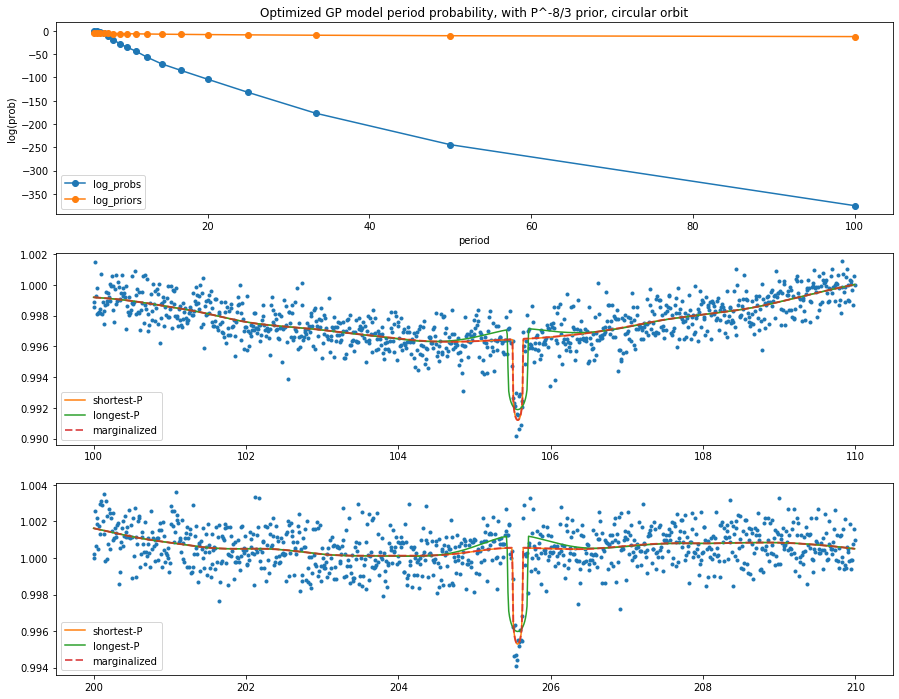

In [23]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_gp_circ["periods"], map_soln_gp_circ["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized GP model period probability, with P^-8/3 prior, circular orbit")
plt.plot(map_soln_gp_circ["periods"],map_soln_gp_circ["logprior_class"],'-o',label='log_priors')
#[map_soln_gp_circ['per_'+str(n)+'_log_prior'] for n in range(17)]
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln_gp_circ["per_16_light_curve"][:1000]+map_soln_gp_circ["per_16_gp_pred"][:1000],label='shortest-P')
plt.plot(x[:1000],map_soln_gp_circ["per_1_light_curve"][:1000]+map_soln_gp_circ["per_1_gp_pred"][:1000],label='longest-P')
plt.plot(x[:1000],map_soln_gp_circ["marginalized_light_curve"][:1000]+map_soln_gp_circ["marginalized_gp_pred"][:1000],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln_gp_circ["per_16_light_curve"][1000:]+map_soln_gp_circ["per_16_gp_pred"][1000:],label='shortest-P')
plt.plot(x[1000:],map_soln_gp_circ["per_1_light_curve"][1000:]+map_soln_gp_circ["per_1_gp_pred"][1000:],label='longest-P')
plt.plot(x[1000:],map_soln_gp_circ["marginalized_light_curve"][1000:]+map_soln_gp_circ["marginalized_gp_pred"][1000:],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

Ok, we're good for circular+GP.

Next stage:

# Adding Complexity - eccentricity


In [24]:
with pm.Model() as model_ecc:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=1.0)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=1.0)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.01, upper=0.1,  testval=np.sqrt(0.00325))
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1) / period_index)
    
    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)
    ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
    omega = xo.distributions.Angle("omega")

    logprobs = []
    logpriors = []
    all_lcs = []
    for i, index in enumerate(period_index):
        with pm.Model(name="per_{0}".format(i), model=model_ecc) as submodel:
            
            period = periods[i]
            
            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0_1, b=b,ecc=ecc,omega=omega)
        
            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            light_curve = pm.Deterministic("light_curve", pm.math.sum(light_curves, axis=-1) + mean)  
            all_lcs.append(light_curve)
            
            # Compute the log prob
            loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            logprior = -8 * tt.log(period) / 3
            logprobs.append(loglike + logprior)
            
            #Adding way to keep track of prior probability and lightcurve
            logpriors.append(logprior)

    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
        
    print(model_ecc.check_test_point())
    map_soln_ecc = xo.optimize(vars=[mean, u, r, b, ecc, omega])
    map_soln_ecc = xo.optimize(map_soln_ecc)

/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


mean               -0.92
t0_1               -0.92
t0_2               -0.92
u_quadlimbdark__   -3.23
r_interval__       -1.39
b_impact__         -1.44
ecc_interval__     -1.85
omega_angle__      -0.50
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [omega, ecc, b, r, u, mean]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:00, 154.30it/s, logp=8.271317e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
122it [00:00, 149.66it/s, logp=8.271317e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: Futu

In [25]:
map_soln_ecc

{'mean': array(0.99912416),
 't0_1': array(105.57020076),
 't0_2': array(205.5668291),
 'u_quadlimbdark__': array([-1.57637123, -0.30570303]),
 'r_interval__': array(0.88911269),
 'b_impact__': array(0.03291584),
 'ecc_interval__': array(-1.25242322),
 'omega_angle__': array([-3.03090559,  3.28840541]),
 'u': array([0.35111963, 0.06277652]),
 'r': array(0.07378363),
 'b': array(0.54572714),
 'periods': array([99.99662834, 49.99831417, 33.33220945, 24.99915708, 19.99932567,
        16.66610472, 14.28523262, 12.49957854, 11.11073648,  9.99966283,
         9.09060258,  8.33305236,  7.69204833,  7.14261631,  6.66644189,
         6.24978927,  5.88215461]),
 'ecc': array(0.2222865),
 'omega': array(-0.74467261),
 'per_0_light_curve': array([0.99912416, 0.99912416, 0.99912416, ..., 0.99912416, 0.99912416,
        0.99912416]),
 'per_1_light_curve': array([0.99912416, 0.99912416, 0.99912416, ..., 0.99912416, 0.99912416,
        0.99912416]),
 'per_2_light_curve': array([0.99912416, 0.99912416,

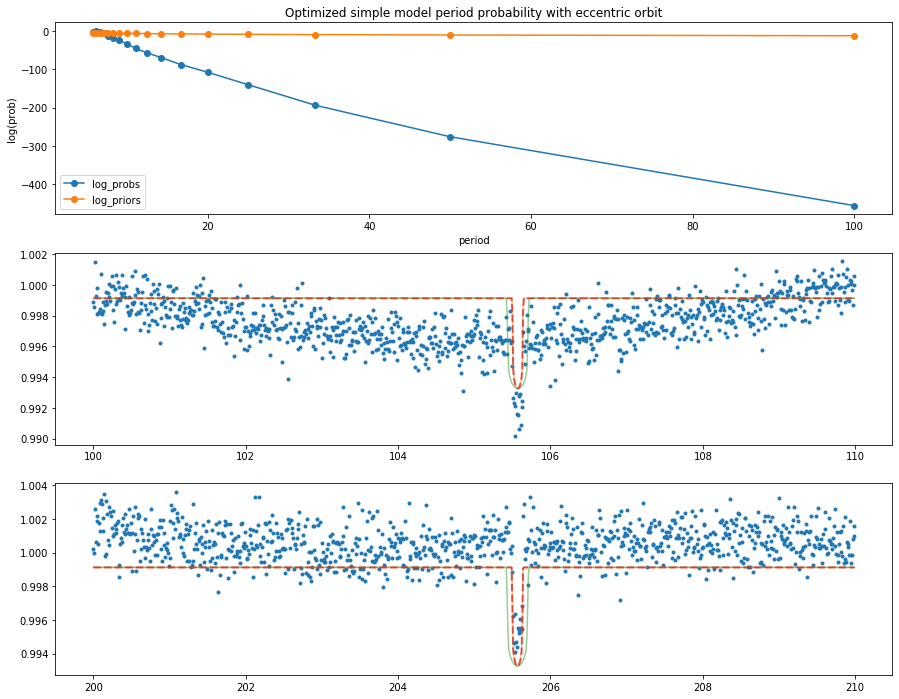

In [26]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_ecc["periods"], map_soln_ecc["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized simple model period probability with eccentric orbit")
plt.plot(map_soln_ecc["periods"],map_soln_ecc["logprior_class"],'-o',label='log_priors')
#[map_soln['per_'+str(n)+'_log_prior'] for n in range(17)],'-o',label='log_priors')
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln_ecc["per_16_light_curve"][:1000],alpha=0.5)
plt.plot(x[:1000],map_soln_ecc["per_1_light_curve"][:1000],alpha=0.5)
plt.plot(x[:1000],map_soln_ecc["marginalized_light_curve"][:1000],'--',alpha=0.75,linewidth=2.0)

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln_ecc["per_16_light_curve"][1000:],alpha=0.5)
plt.plot(x[1000:],map_soln_ecc["per_1_light_curve"][1000:],alpha=0.5)
plt.plot(x[1000:],map_soln_ecc["marginalized_light_curve"][1000:],'--',alpha=0.75,linewidth=2.0)

# Let's try putting ecc & omega inside the submodel

In [27]:
with pm.Model() as model_ecc_2:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=1.0)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=1.0)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.01, upper=0.1,  testval=np.sqrt(0.00325))
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1) / period_index)
    
    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)

    logprobs = []
    logpriors = []
    all_lcs = []
    for i, index in enumerate(period_index):
        with pm.Model(name="per_{0}".format(i), model=model_ecc_2) as submodel:
            
            period = periods[i]
            ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, testval=np.random.random())
            omega = xo.distributions.Angle("omega")

            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0_1, b=b,
                                             ecc=ecc,omega=omega)
        
            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            light_curve = pm.Deterministic("light_curve", pm.math.sum(light_curves, axis=-1) + mean)  
            all_lcs.append(light_curve)
            
            # Compute the log prob
            loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            logprior = -8 * tt.log(period) / 3
            logprobs.append(loglike + logprior)
            
            #Adding way to keep track of prior probability and lightcurve
            logpriors.append(logprior)

    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
        
    print(model_ecc_2.check_test_point())
    map_soln_ecc_2 = xo.optimize(vars=[mean, u, r, b, ecc, omega])
    map_soln_ecc_2 = xo.optimize(map_soln_ecc_2)

mean                    -0.92
t0_1                    -0.92
t0_2                    -0.92
u_quadlimbdark__        -3.23
r_interval__            -1.39
b_impact__              -1.44
per_0_ecc_interval__    -4.03
per_0_omega_angle__     -0.50
per_1_ecc_interval__    -8.94
per_1_omega_angle__     -0.50
per_2_ecc_interval__    -3.69
per_2_omega_angle__     -0.50
per_3_ecc_interval__    -1.74
per_3_omega_angle__     -0.50
per_4_ecc_interval__    -1.47
per_4_omega_angle__     -0.50
per_5_ecc_interval__    -1.30
per_5_omega_angle__     -0.50
per_6_ecc_interval__    -6.32
per_6_omega_angle__     -0.50
per_7_ecc_interval__    -2.81
per_7_omega_angle__     -0.50
per_8_ecc_interval__    -4.17
per_8_omega_angle__     -0.50
per_9_ecc_interval__    -5.26
per_9_omega_angle__     -0.50
per_10_ecc_interval__   -1.61
per_10_omega_angle__    -0.50
per_11_ecc_interval__   -2.12
per_11_omega_angle__    -0.50
per_12_ecc_interval__   -4.00
per_12_omega_angle__    -0.50
per_13_ecc_interval__   -9.44
per_13_ome

optimizing logp for variables: [per_16_omega, per_16_ecc, b, r, u, mean]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
75it [00:00, 177.71it/s, logp=8.202431e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
87it [00:00, 177.71it/s, logp=8.202431e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.p

In [28]:
map_soln_ecc_2

{'mean': array(0.9991242),
 't0_1': array(105.57018709),
 't0_2': array(205.56688931),
 'u_quadlimbdark__': array([-1.61297032, -0.28885641]),
 'r_interval__': array(0.88753951),
 'b_impact__': array(0.01086323),
 'per_0_ecc_interval__': array(-1.25126342),
 'per_0_omega_angle__': array([-1.67209003e-05,  4.47213591e+00]),
 'per_1_ecc_interval__': array(-1.25126336),
 'per_1_omega_angle__': array([0.00875102, 4.47212728]),
 'per_2_ecc_interval__': array(-1.25126352),
 'per_2_omega_angle__': array([-2.69853849, -3.56621522]),
 'per_3_ecc_interval__': array(-1.25126343),
 'per_3_omega_angle__': array([2.57695015, 3.65504131]),
 'per_4_ecc_interval__': array(-1.25126337),
 'per_4_omega_angle__': array([-4.43865276, -0.54622544]),
 'per_5_ecc_interval__': array(-1.2512633),
 'per_5_omega_angle__': array([0.22341632, 4.46655172]),
 'per_6_ecc_interval__': array(-1.25126339),
 'per_6_omega_angle__': array([-7.35510093e-04,  4.47213557e+00]),
 'per_7_ecc_interval__': array(-1.24965201),
 'per

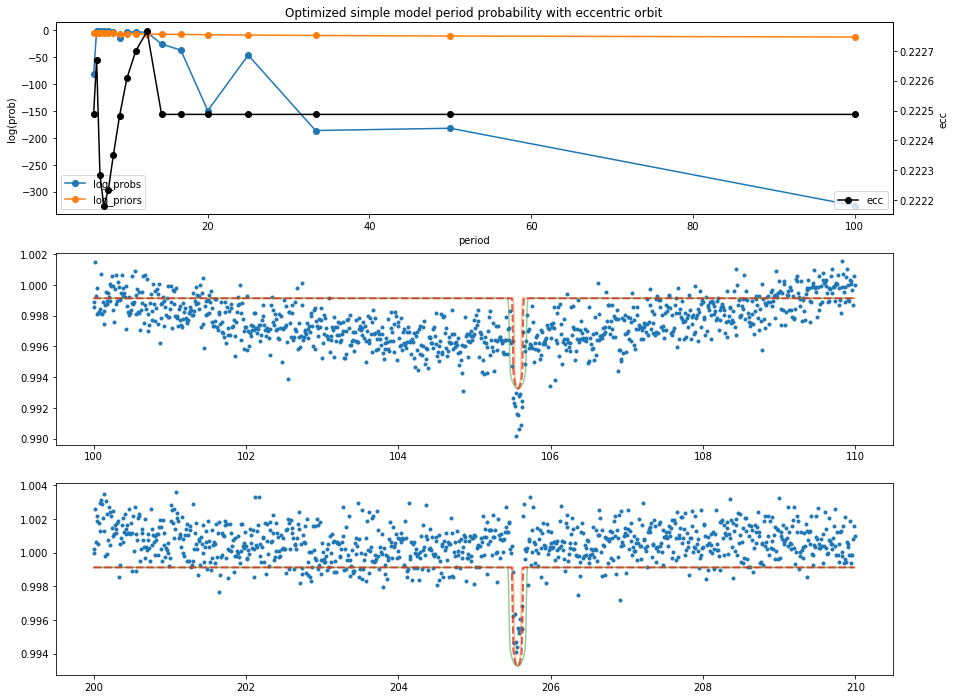

In [29]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_ecc_2["periods"], map_soln_ecc_2["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized simple model period probability with eccentric orbit")
plt.plot(map_soln_ecc_2["periods"],map_soln_ecc_2["logprior_class"],'-o',label='log_priors')
plt.ylabel('log(prob)')
plt.legend(loc=3)
ax2 = plt.gca().twinx()
ax2.set_ylabel('ecc')  # we already handled the x-label with ax1
#ax2.plot(map_soln_ecc_2["periods"], [map_soln_ecc_2['per_'+str(n)+'_omega'] for n in range(17)],'-or',label='omega')
ax2.plot(map_soln_ecc_2["periods"], [map_soln_ecc_2['per_'+str(n)+'_ecc'] for n in range(17)],'-ok',label='ecc')
#[map_soln['per_'+str(n)+'_log_prior'] for n in range(17)],'-o',label='log_priors')
plt.legend(loc=4)

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln_ecc_2["per_16_light_curve"][:1000],alpha=0.5)
plt.plot(x[:1000],map_soln_ecc_2["per_1_light_curve"][:1000],alpha=0.5)
plt.plot(x[:1000],map_soln_ecc_2["marginalized_light_curve"][:1000],'--',alpha=0.75,linewidth=2.0)

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln_ecc_2["per_16_light_curve"][1000:],alpha=0.5)
plt.plot(x[1000:],map_soln_ecc_2["per_1_light_curve"][1000:],alpha=0.5)
plt.plot(x[1000:],map_soln_ecc_2["marginalized_light_curve"][1000:],'--',alpha=0.75,linewidth=2.0)

Ok, that's slightly weird - why is the 33d period now the most likely? And why is eccentricity so stuck at 0.222?

# Adding both GPs & eccentricity

But let's not marginalise over ecc or omega just yet

In [30]:
with pm.Model() as model_gp_ecc:

    #Baseline flux is now in the GPs, so deleting this:
    #mean = pm.Normal("mean", mu=1.0, sd=1.0)

    Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
    logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
    rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))
             
    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=0.4)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=0.4)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.001, upper=0.3)
    ror=pm.Deterministic("ror", r/Rs)
    b = xo.distributions.ImpactParameter("b", ror=ror, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1)/period_index)
    
    #Jitter term. Initialised with the std of y
    logs2 = pm.Normal("logs2", mu=np.log(np.std(y)),sd=1.0,testval=np.log(np.std(y)))
    
    #Guess P_var=10d to begin:
    logw0_guess = np.log(2*np.pi/10)

    #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
    min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
    lcrange=x[-1]-x[0]
    logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                       upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
    logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Initialising GP model for the light curve
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)
    
    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)
    ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
    omega = xo.distributions.Angle("omega")

    logprobs = []
    logpriors= []
    all_lcs = []
    gp_preds = []
    for i, index in enumerate(period_index):

        with pm.Model(name="per_{0}".format(i), model=model_gp_ecc) as submodel:
            
            period = periods[i]
            
            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(
                    period=period, t0=t0_1, b=b,
                    ecc=ecc,omega=omega)
            
            #Adding deterministic tdur
            vx, vy, vz = orbit.get_relative_velocity(t0_1) #To calculate Tdur
            vrel=pm.Deterministic("vrel",tt.sqrt(vx**2 + vy**2)/Rs)
            tdur=pm.Deterministic("tdur",(2*tt.sqrt(1-b**2))/vrel)

            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            lc=pm.math.sum(light_curves, axis=-1)
            light_curve = pm.Deterministic("light_curve",lc) 
            
            # Compute the log prob
            #loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            loglike = tt.sum(gp.log_likelihood(y - light_curve))
            gp_pred = pm.Deterministic("gp_pred", gp.predict())
            gp_preds.append(gp.predict())
            
            all_lcs.append(lc)

            #Computing log prior.
            #Here we'll use P^-8/3 (occurrence rate (P^-1) * window function (P^-1) * transit probability (P^-2/3) )
            logprior = -8 / 3 * tt.log(period) 
            logprobs.append(loglike + logprior)
            logpriors.append(logprior)

    
    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    
    gp_preds_all = tt.stack(gp_preds)
    
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve and gp prediction
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
    pm.Deterministic("marginalized_gp_pred", tt.sum(tt.stack(gp_preds) * tt.exp(logprob_class)[:, None], axis=0))
    
    #Optimising:
    print(model_gp_ecc.test_point)
    print(model_gp_ecc.check_test_point())
    map_soln_gp_ecc = xo.optimize(vars=[r, b])
    map_soln_gp_ecc = xo.optimize(start=map_soln_gp_ecc, vars=[logs2])
    map_soln_gp_ecc = xo.optimize(start=map_soln_gp_ecc, vars=[t0_1, t0_2])
    map_soln_gp_ecc = xo.optimize(start=map_soln_gp_ecc, vars=[logs2, logpower])
    map_soln_gp_ecc = xo.optimize(start=map_soln_gp_ecc, vars=[logw0])
    map_soln_gp_ecc = xo.optimize(start=map_soln_gp_ecc, vars=[r,b,ecc,Rs,u])

    map_soln_gp_ecc = xo.optimize(map_soln_gp_ecc)
    

{'Rs': array(1.), 'logrho_S': array(0.), 't0_1': array(105.57), 't0_2': array(205.57), 'u_quadlimbdark__': array([-1.09861229, -0.84729786]), 'r_interval__': array(0.), 'b_impact__': array(-0.59116847), 'logs2': array(-6.20283651), 'logw0_interval__': array(-0.60183699), 'logpower_interval__': array(1.20816619), 'ecc_interval__': array(-1.11022302e-16), 'omega_angle__': array([0., 1.])}
Rs                     0.29
logrho_S              -0.23
t0_1                  -0.00
t0_2                  -0.00
u_quadlimbdark__      -3.23
r_interval__          -1.39
b_impact__            -1.47
logs2                 -0.92
logw0_interval__      -1.48
logpower_interval__   -1.73
ecc_interval__        -1.85
omega_angle__         -0.50
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [b, r, Rs]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
14it [00:00, 139.81it/s, logp=-1.649929e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
15it [00:11,  1.33it/s, logp=-1.649929e+04] 
message: Optimization terminated successfully.
logp: -16508.66074507466 -> -16499.28636

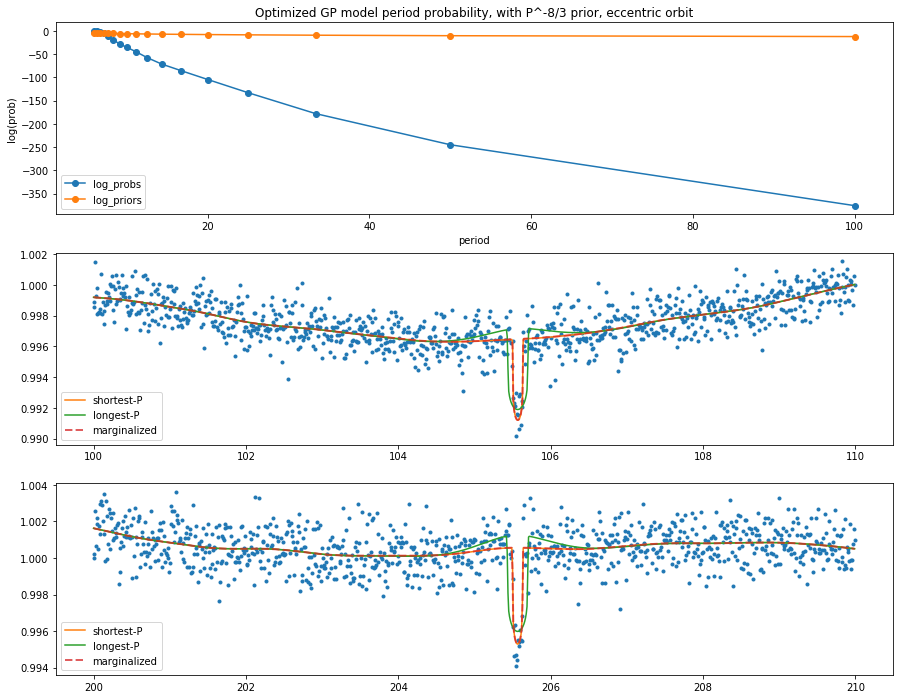

In [31]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_gp_ecc["periods"], map_soln_gp_ecc["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized GP model period probability, with P^-8/3 prior, eccentric orbit")
plt.plot(map_soln_gp_ecc["periods"],map_soln_gp_ecc["logprior_class"],'-o',label='log_priors')
#[map_soln_gp_ecc['per_'+str(n)+'_log_prior'] for n in range(17)]
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln_gp_ecc["per_16_light_curve"][:1000]+map_soln_gp_ecc["per_16_gp_pred"][:1000],label='shortest-P')
plt.plot(x[:1000],map_soln_gp_ecc["per_1_light_curve"][:1000]+map_soln_gp_ecc["per_1_gp_pred"][:1000],label='longest-P')
plt.plot(x[:1000],map_soln_gp_ecc["marginalized_light_curve"][:1000]+map_soln_gp_ecc["marginalized_gp_pred"][:1000],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln_gp_ecc["per_16_light_curve"][1000:]+map_soln_gp_ecc["per_16_gp_pred"][1000:],label='shortest-P')
plt.plot(x[1000:],map_soln_gp_ecc["per_1_light_curve"][1000:]+map_soln_gp_ecc["per_1_gp_pred"][1000:],label='longest-P')
plt.plot(x[1000:],map_soln_gp_ecc["marginalized_light_curve"][1000:]+map_soln_gp_ecc["marginalized_gp_pred"][1000:],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

Now we're going the other way! The longest period solution is most favoured! And I can't really see why...

# Marginalising over ecc & omega (with GPs)

In [32]:
with pm.Model() as model_gp_marg_ecc:

    #Baseline flux is now in the GPs, so deleting this:
    #mean = pm.Normal("mean", mu=1.0, sd=1.0)

    Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
    logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
    rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))
             
    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=0.4)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=0.4)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.001, upper=0.3)
    ror=pm.Deterministic("ror", r/Rs)
    b = xo.distributions.ImpactParameter("b", ror=ror, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1)/period_index)
    
    #Jitter term. Initialised with the std of y
    logs2 = pm.Normal("logs2", mu=np.log(np.std(y)),sd=1.0,testval=np.log(np.std(y)))
    
    #Guess P_var=10d to begin:
    logw0_guess = np.log(2*np.pi/10)

    #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
    min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
    lcrange=x[-1]-x[0]
    logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                       upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
    logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Initialising GP model for the light curve
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)
    
    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)

    logprobs = []
    logpriors= []
    all_lcs = []
    gp_preds = []
    for i, index in enumerate(period_index):

        with pm.Model(name="per_{0}".format(i), model=model_gp_marg_ecc) as submodel:
            
            period = pm.Deterministic("period", periods[i])
            ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
            omega = xo.distributions.Angle("omega")

            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(
                    period=period, t0=t0_1, b=b,
                    ecc=ecc,omega=omega)
            
            #Adding deterministic tdur
            vx, vy, vz = orbit.get_relative_velocity(t0_1) #To calculate Tdur
            vrel=pm.Deterministic("vrel",tt.sqrt(vx**2 + vy**2)/Rs)
            tdur=pm.Deterministic("tdur",(2*tt.sqrt(1-b**2))/vrel)

            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            lc=pm.math.sum(light_curves, axis=-1)
            light_curve = pm.Deterministic("light_curve",lc) 
            
            # Compute the log prob
            #loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            loglike = tt.sum(gp.log_likelihood(y - light_curve))
            gp_pred = pm.Deterministic("gp_pred", gp.predict())
            gp_preds.append(gp.predict())
            
            all_lcs.append(lc)

            #Computing log prior.
            #Here we'll use P^-8/3 (occurrence rate (P^-1) * window function (P^-1) * transit probability (P^-2/3) )
            logprior = -8 * tt.log(period) / 3
            logprobs.append(loglike + logprior)
            logpriors.append(logprior)

    
    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    
    gp_preds_all = tt.stack(gp_preds)
    
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve and gp prediction
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
    pm.Deterministic("marginalized_gp_pred", tt.sum(tt.stack(gp_preds) * tt.exp(logprob_class)[:, None], axis=0))
    
    #Optimising:
    print(model_gp_marg_ecc.test_point)
    print(model_gp_marg_ecc.check_test_point())
    map_soln_gp_marg_ecc = xo.optimize(vars=[r, b])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[t0_1, t0_2])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2, logpower])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logw0])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[r,b,ecc,Rs,u])

    map_soln_gp_marg_ecc = xo.optimize(map_soln_gp_marg_ecc)
    

{'Rs': array(1.), 'logrho_S': array(0.), 't0_1': array(105.57), 't0_2': array(205.57), 'u_quadlimbdark__': array([-1.09861229, -0.84729786]), 'r_interval__': array(0.), 'b_impact__': array(-0.59116847), 'logs2': array(-6.20283651), 'logw0_interval__': array(-0.60183699), 'logpower_interval__': array(1.20816619), 'per_0_ecc_interval__': array(-1.11022302e-16), 'per_0_omega_angle__': array([0., 1.]), 'per_1_ecc_interval__': array(-1.11022302e-16), 'per_1_omega_angle__': array([0., 1.]), 'per_2_ecc_interval__': array(-1.11022302e-16), 'per_2_omega_angle__': array([0., 1.]), 'per_3_ecc_interval__': array(-1.11022302e-16), 'per_3_omega_angle__': array([0., 1.]), 'per_4_ecc_interval__': array(-1.11022302e-16), 'per_4_omega_angle__': array([0., 1.]), 'per_5_ecc_interval__': array(-1.11022302e-16), 'per_5_omega_angle__': array([0., 1.]), 'per_6_ecc_interval__': array(-1.11022302e-16), 'per_6_omega_angle__': array([0., 1.]), 'per_7_ecc_interval__': array(-1.11022302e-16), 'per_7_omega_angle__':

optimizing logp for variables: [b, r, Rs]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
15it [00:00, 139.74it/s, logp=-1.653690e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
15it [00:13,  1.13it/s, logp=-1.653690e+04] 
message: Optimization terminated successfully.
logp: -16546.271592267076 -> -16536.8972

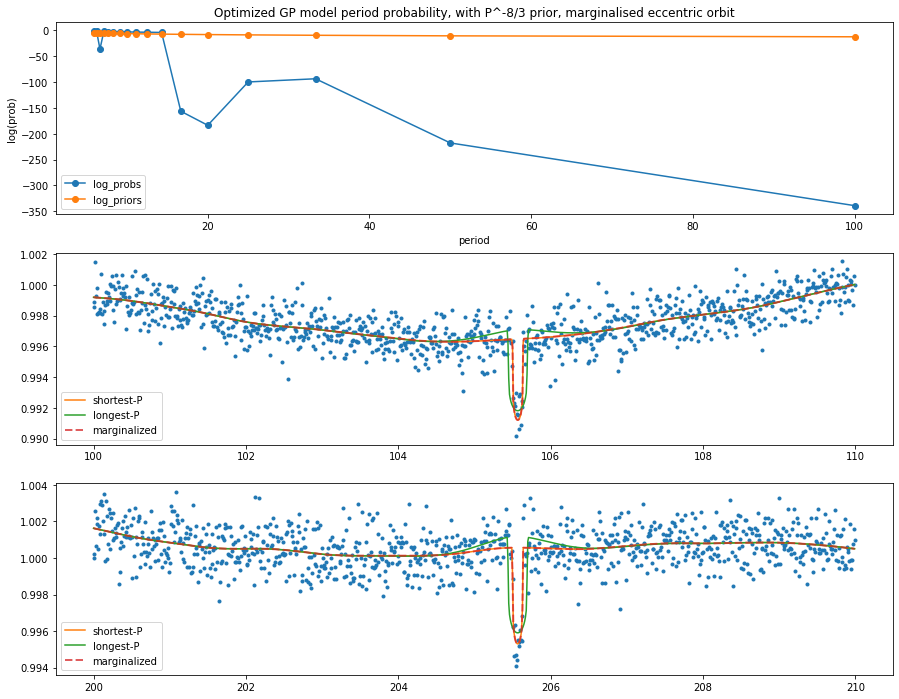

In [33]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_gp_marg_ecc["periods"], map_soln_gp_marg_ecc["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized GP model period probability, with P^-8/3 prior, marginalised eccentric orbit")
plt.plot(map_soln_gp_marg_ecc["periods"],map_soln_gp_marg_ecc["logprior_class"],'-o',label='log_priors')
#[map_soln_gp_marg_ecc['per_'+str(n)+'_log_prior'] for n in range(17)]
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln_gp_marg_ecc["per_16_light_curve"][:1000]+map_soln_gp_marg_ecc["per_16_gp_pred"][:1000],label='shortest-P')
plt.plot(x[:1000],map_soln_gp_marg_ecc["per_1_light_curve"][:1000]+map_soln_gp_marg_ecc["per_1_gp_pred"][:1000],label='longest-P')
plt.plot(x[:1000],map_soln_gp_marg_ecc["marginalized_light_curve"][:1000]+map_soln_gp_marg_ecc["marginalized_gp_pred"][:1000],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln_gp_marg_ecc["per_16_light_curve"][1000:]+map_soln_gp_marg_ecc["per_16_gp_pred"][1000:],label='shortest-P')
plt.plot(x[1000:],map_soln_gp_marg_ecc["per_1_light_curve"][1000:]+map_soln_gp_marg_ecc["per_1_gp_pred"][1000:],label='longest-P')
plt.plot(x[1000:],map_soln_gp_marg_ecc["marginalized_light_curve"][1000:]+map_soln_gp_marg_ecc["marginalized_gp_pred"][1000:],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

Ok, so that has gone seriously hay-wire. Not sure what on earth is causing that.

# Incorporating logp from eccentricity in marginalisation

Currently, when we do this marginalisation, I don't think we include information from the prior (namely that high-e orbits are less likely). But I'm not 100% sure on this.

I would, naively, think this should push solutions to short-period, however I guess it's possible that the long-P option is also eccentric and isn't being adequately supressed? So let's try to extract the prior on the eccentricity and 

In [34]:
with pm.Model() as model_gp_marg_ecc_2:

    #Baseline flux is now in the GPs, so deleting this:
    #mean = pm.Normal("mean", mu=1.0, sd=1.0)

    Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
    logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
    rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))
             
    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=0.4)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=0.4)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.001, upper=0.3)
    ror=pm.Deterministic("ror", r/Rs)
    b = xo.distributions.ImpactParameter("b", ror=ror, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1)/period_index)
    
    #Jitter term. Initialised with the std of y
    logs2 = pm.Normal("logs2", mu=np.log(np.std(y)),sd=1.0,testval=np.log(np.std(y)))
    
    #Guess P_var=10d to begin:
    logw0_guess = np.log(2*np.pi/10)

    #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
    min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
    lcrange=x[-1]-x[0]
    logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                       upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
    logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Initialising GP model for the light curve
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)
    
    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)

    logprobs = []
    logpriors= []
    all_lcs = []
    gp_preds = []
    for i, index in enumerate(period_index):

        with pm.Model(name="per_{0}".format(i), model=model_gp_marg_ecc_2) as submodel:
            
            period = pm.Deterministic("period", periods[i])
            ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
            omega = xo.distributions.Angle("omega")

            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(
                    period=period, t0=t0_1, b=b,
                    ecc=ecc,omega=omega)
            
            #Adding deterministic tdur
            vx, vy, vz = orbit.get_relative_velocity(t0_1) #To calculate Tdur
            vrel=pm.Deterministic("vrel",tt.sqrt(vx**2 + vy**2)/Rs)
            tdur=pm.Deterministic("tdur",(2*tt.sqrt(1-b**2))/vrel)

            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            lc=pm.math.sum(light_curves, axis=-1)
            light_curve = pm.Deterministic("light_curve",lc) 
            
            # Compute the log prob
            #loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            loglike = tt.sum(gp.log_likelihood(y - light_curve))
            gp_pred = pm.Deterministic("gp_pred", gp.predict())
            gp_preds.append(gp.predict())
            
            all_lcs.append(lc)

            #Computing log prior.
            #Here we'll use P^-8/3 (occurrence rate (P^-1) * window function (P^-1) * transit probability (P^-2/3) )
            # We also need to include the log probabilities of the other marginalised variables - ecc & omega
            '''print(submodel.test_point)
            exec("submodel_ecc_int='per_"+str(i)+"_ecc_interval__'")
            print(submodel.test_point[submodel_ecc_int])
            print(submodel.ecc_interval__.logp(submodel.test_point))'''
            print("ecc_logp at p=",periods[i],submodel.ecc_interval__.logp(submodel.test_point))
            logprior = -8 * tt.log(period) / 3 + submodel.ecc_interval__.logp(submodel.test_point)
            logprobs.append(loglike + logprior)
            logpriors.append(logprior)

    
    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    
    gp_preds_all = tt.stack(gp_preds)
    
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve and gp prediction
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
    pm.Deterministic("marginalized_gp_pred", tt.sum(tt.stack(gp_preds) * tt.exp(logprob_class)[:, None], axis=0))
    
    #Optimising:
    print(model_gp_marg_ecc_2.test_point)
    print(model_gp_marg_ecc_2.check_test_point())
    map_soln_gp_marg_ecc_2 = xo.optimize(vars=[r, b])
    map_soln_gp_marg_ecc_2 = xo.optimize(start=map_soln_gp_marg_ecc_2, vars=[logs2])
    map_soln_gp_marg_ecc_2 = xo.optimize(start=map_soln_gp_marg_ecc_2, vars=[t0_1, t0_2])
    map_soln_gp_marg_ecc_2 = xo.optimize(start=map_soln_gp_marg_ecc_2, vars=[logs2, logpower])
    map_soln_gp_marg_ecc_2 = xo.optimize(start=map_soln_gp_marg_ecc_2, vars=[logw0])
    map_soln_gp_marg_ecc_2 = xo.optimize(start=map_soln_gp_marg_ecc_2, vars=[r,b,ecc,Rs,u])

    map_soln_gp_marg_ecc_2 = xo.optimize(map_soln_gp_marg_ecc_2)
    

ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
ecc_logp at p= Subtensor{int64}.0 -1.8506779495259122
{'Rs': array(1.), 'logrho_S': array(0.), 't0_1': array(105.57), 't0_2': array(205.

optimizing logp for variables: [b, r, Rs]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
14it [00:00, 127.94it/s, logp=-1.653875e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
15it [00:15,  1.01s/it, logp=-1.653875e+04] 
message: Optimization terminated successfully.
logp: -16548.1222702166 -> -16538.747894

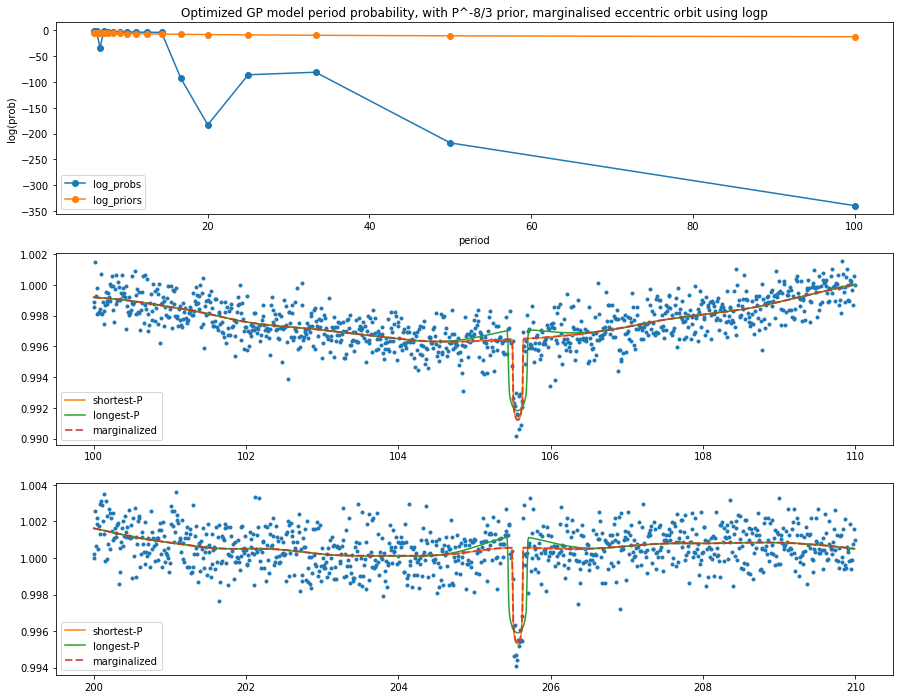

In [35]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_gp_marg_ecc_2["periods"], map_soln_gp_marg_ecc_2["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized GP model period probability, with P^-8/3 prior, marginalised eccentric orbit using logp")
plt.plot(map_soln_gp_marg_ecc_2["periods"],map_soln_gp_marg_ecc["logprior_class"],'-o',label='log_priors')
#[map_soln_gp_marg_ecc['per_'+str(n)+'_log_prior'] for n in range(17)]
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln_gp_marg_ecc_2["per_16_light_curve"][:1000]+map_soln_gp_marg_ecc_2["per_16_gp_pred"][:1000],label='shortest-P')
plt.plot(x[:1000],map_soln_gp_marg_ecc_2["per_1_light_curve"][:1000]+map_soln_gp_marg_ecc_2["per_1_gp_pred"][:1000],label='longest-P')
plt.plot(x[:1000],map_soln_gp_marg_ecc_2["marginalized_light_curve"][:1000]+map_soln_gp_marg_ecc_2["marginalized_gp_pred"][:1000],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln_gp_marg_ecc_2["per_16_light_curve"][1000:]+map_soln_gp_marg_ecc_2["per_16_gp_pred"][1000:],label='shortest-P')
plt.plot(x[1000:],map_soln_gp_marg_ecc_2["per_1_light_curve"][1000:]+map_soln_gp_marg_ecc_2["per_1_gp_pred"][1000:],label='longest-P')
plt.plot(x[1000:],map_soln_gp_marg_ecc_2["marginalized_light_curve"][1000:]+map_soln_gp_marg_ecc_2["marginalized_gp_pred"][1000:],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

# Changing the prior

Using a prior purely from period is simple, but is actually wrong for eccentric orbits as it assumes  no input from eccentricity $$p \alpha P^{2/3}$$. 

What we want is to maintain the period prior for occurrence rates and window function, but use computed distance during transit for the geometric prior 

In [36]:
with pm.Model() as model_gp_marg_ecc_newprior:

    #Baseline flux is now in the GPs, so deleting this:
    #mean = pm.Normal("mean", mu=1.0, sd=1.0)

    Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
    logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
    rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))
             
    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=0.4)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=0.4)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.001, upper=0.3)
    ror=pm.Deterministic("ror", r/Rs)
    b = xo.distributions.ImpactParameter("b", ror=ror, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1)/period_index)
    
    #Jitter term. Initialised with the std of y
    logs2 = pm.Normal("logs2", mu=np.log(np.std(y)),sd=1.0,testval=np.log(np.std(y)))
    
    #Guess P_var=10d to begin:
    logw0_guess = np.log(2*np.pi/10)

    #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
    min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
    lcrange=x[-1]-x[0]
    logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                       upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
    logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Initialising GP model for the light curve
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)
    
    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)

    logprobs = []
    logpriors= []
    all_lcs = []
    gp_preds = []
    for i, index in enumerate(period_index):

        with pm.Model(name="per_{0}".format(i), model=model_gp_marg_ecc_newprior) as submodel:
            
            period = periods[i]
            ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
            omega = xo.distributions.Angle("omega")

            # Set up a Keplerian orbit for the planets
            orbit = xo.orbits.KeplerianOrbit(
                    period=period, t0=t0_1, b=b,
                    ecc=ecc,omega=omega)
            
            #Adding deterministic tdur
            vx, vy, vz = orbit.get_relative_velocity(t0_1) #To calculate Tdur
            vrel=pm.Deterministic("vrel",tt.sqrt(vx**2 + vy**2)/Rs)
            tdur=pm.Deterministic("tdur",(2*tt.sqrt(1-b**2))/vrel)

            # Compute the model light curve using starry
            light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
            lc=pm.math.sum(light_curves, axis=-1)
            light_curve = pm.Deterministic("light_curve",lc) 
            
            # Compute the log prob
            #loglike = tt.sum(pm.Normal.dist(mu=light_curve, sd=yerr).logp(y))
            loglike = tt.sum(gp.log_likelihood(y - light_curve))
            gp_pred = pm.Deterministic("gp_pred", gp.predict())
            gp_preds.append(gp.predict())
            
            all_lcs.append(lc)

            #Computing log prior.
            #Here we'll use P^-8/3 (occurrence rate (P^-1) * window function (P^-1) * transit probability (P^-2/3) )
            d_x,d_y,d_z = orbit.get_relative_position(t0_1) #Need this to marginalise over 1/a and not just P^-5/3
            logprior = -2 * tt.log(period)-1*tt.log(tt.mean(d_z))#taking an average of the t0 
            logprobs.append(loglike + logprior)
            logpriors.append(logprior)
    
    # Compute the marginalized probability and the posterior probability for each period
    logprobs = tt.stack(logprobs)
    logprob_marg = pm.math.logsumexp(logprobs)
    logprob_class = pm.Deterministic("logprob_class", logprobs - logprob_marg)
    logprior_class = pm.Deterministic("logprior_class", tt.stack(logpriors))
    
    gp_preds_all = tt.stack(gp_preds)
    
    pm.Potential("logprob", logprob_marg)
    
    # Compute the marginalized light curve and gp prediction
    pm.Deterministic("marginalized_light_curve", tt.sum(tt.stack(all_lcs) * tt.exp(logprob_class)[:, None], axis=0))
    pm.Deterministic("marginalized_gp_pred", tt.sum(tt.stack(gp_preds) * tt.exp(logprob_class)[:, None], axis=0))
    
    #Optimising:
    print(model_gp_marg_ecc_newprior.test_point)
    print(model_gp_marg_ecc_newprior.check_test_point())
    map_soln_gp_marg_ecc_newprior = xo.optimize(vars=[r, b])
    map_soln_gp_marg_ecc_newprior = xo.optimize(start=map_soln_gp_marg_ecc_newprior, vars=[logs2])
    map_soln_gp_marg_ecc_newprior = xo.optimize(start=map_soln_gp_marg_ecc_newprior, vars=[t0_1, t0_2])
    map_soln_gp_marg_ecc_newprior = xo.optimize(start=map_soln_gp_marg_ecc_newprior, vars=[logs2, logpower])
    map_soln_gp_marg_ecc_newprior = xo.optimize(start=map_soln_gp_marg_ecc_newprior, vars=[logw0])
    map_soln_gp_marg_ecc_newprior = xo.optimize(start=map_soln_gp_marg_ecc_newprior, vars=[r,b,ecc,Rs,u])

    map_soln_gp_marg_ecc_newprior = xo.optimize(map_soln_gp_marg_ecc_newprior)
    

/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


{'Rs': array(1.), 'logrho_S': array(0.), 't0_1': array(105.57), 't0_2': array(205.57), 'u_quadlimbdark__': array([-1.09861229, -0.84729786]), 'r_interval__': array(0.), 'b_impact__': array(-0.59116847), 'logs2': array(-6.20283651), 'logw0_interval__': array(-0.60183699), 'logpower_interval__': array(1.20816619), 'per_0_ecc_interval__': array(-1.11022302e-16), 'per_0_omega_angle__': array([0., 1.]), 'per_1_ecc_interval__': array(-1.11022302e-16), 'per_1_omega_angle__': array([0., 1.]), 'per_2_ecc_interval__': array(-1.11022302e-16), 'per_2_omega_angle__': array([0., 1.]), 'per_3_ecc_interval__': array(-1.11022302e-16), 'per_3_omega_angle__': array([0., 1.]), 'per_4_ecc_interval__': array(-1.11022302e-16), 'per_4_omega_angle__': array([0., 1.]), 'per_5_ecc_interval__': array(-1.11022302e-16), 'per_5_omega_angle__': array([0., 1.]), 'per_6_ecc_interval__': array(-1.11022302e-16), 'per_6_omega_angle__': array([0., 1.]), 'per_7_ecc_interval__': array(-1.11022302e-16), 'per_7_omega_angle__':

optimizing logp for variables: [b, r, Rs]
0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
14it [00:00, 122.50it/s, logp=-1.653805e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
15it [00:14,  1.04it/s, logp=-1.653805e+04] 
message: Optimization terminated successfully.
logp: -16547.420266041576 -> -16538.0452

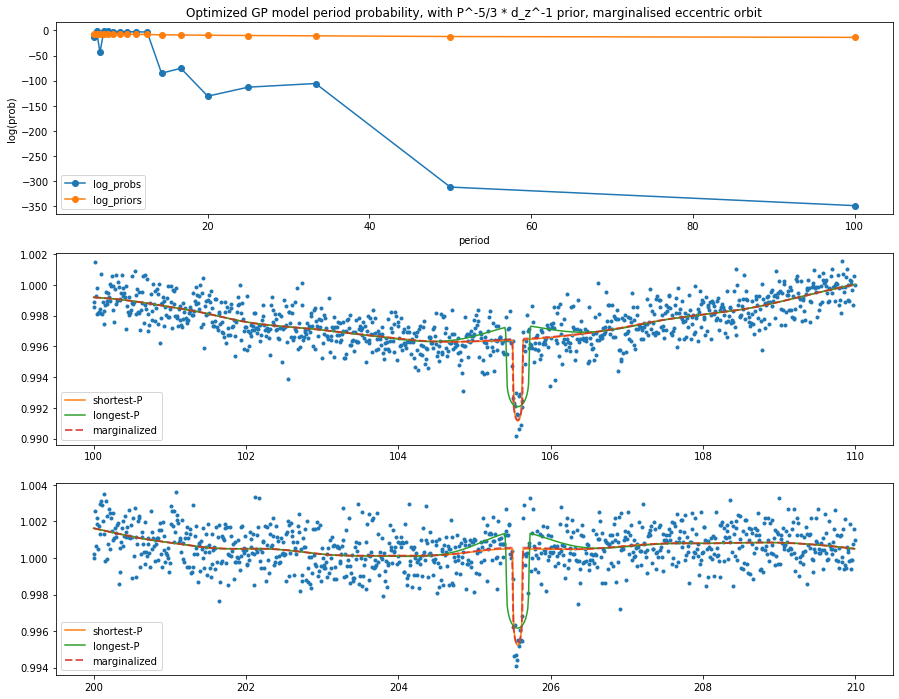

In [37]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_gp_marg_ecc_newprior["periods"], map_soln_gp_marg_ecc_newprior["logprob_class"], "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized GP model period probability, with P^-5/3 * d_z^-1 prior, marginalised eccentric orbit")
plt.plot(map_soln_gp_marg_ecc_newprior["periods"],map_soln_gp_marg_ecc_newprior["logprior_class"],'-o',label='log_priors')
#[map_soln_gp_marg_ecc['per_'+str(n)+'_log_prior'] for n in range(17)]
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln_gp_marg_ecc_newprior["per_16_light_curve"][:1000]+map_soln_gp_marg_ecc_newprior["per_16_gp_pred"][:1000],label='shortest-P')
plt.plot(x[:1000],map_soln_gp_marg_ecc_newprior["per_1_light_curve"][:1000]+map_soln_gp_marg_ecc_newprior["per_1_gp_pred"][:1000],label='longest-P')
plt.plot(x[:1000],map_soln_gp_marg_ecc_newprior["marginalized_light_curve"][:1000]+map_soln_gp_marg_ecc_newprior["marginalized_gp_pred"][:1000],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln_gp_marg_ecc_newprior["per_16_light_curve"][1000:]+map_soln_gp_marg_ecc_newprior["per_16_gp_pred"][1000:],label='shortest-P')
plt.plot(x[1000:],map_soln_gp_marg_ecc_newprior["per_1_light_curve"][1000:]+map_soln_gp_marg_ecc_newprior["per_1_gp_pred"][1000:],label='longest-P')
plt.plot(x[1000:],map_soln_gp_marg_ecc_newprior["marginalized_light_curve"][1000:]+map_soln_gp_marg_ecc_newprior["marginalized_gp_pred"][1000:],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

# Sampling with Pymc3:

In [38]:
np.random.seed(42)
with model_gp_marg_ecc_newprior:
    trace_gp_marg_ecc_newprior = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln_gp_marg_ecc_newprior,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [per_16_omega, per_16_ecc, per_15_omega, per_15_ecc, per_14_omega, per_14_ecc, per_13_omega, per_13_ecc, per_12_omega, per_12_ecc, per_11_omega, per_11_ecc, per_10_omega, per_10_ecc, per_9_omega, per_9_ecc, per_8_omega, per_8_ecc, per_7_omega, per_7_ecc, per_6_omega, per_6_ecc, per_5_omega, per_5_ecc, per_4_omega, per_4_ecc, per_3_omega, per_3_ecc, per_2_omega, per_2_ecc, per_1_omega, per_1_ecc, per_0_omega, per_0_ecc, logpower, logw0, logs2, b, r, u, t0_2, t0_1, logrho_S, Rs]
Sampling 2 chains, 5 divergences: 100%|██████████| 8000/8000 [1:10:20<00:00,  1.90draws

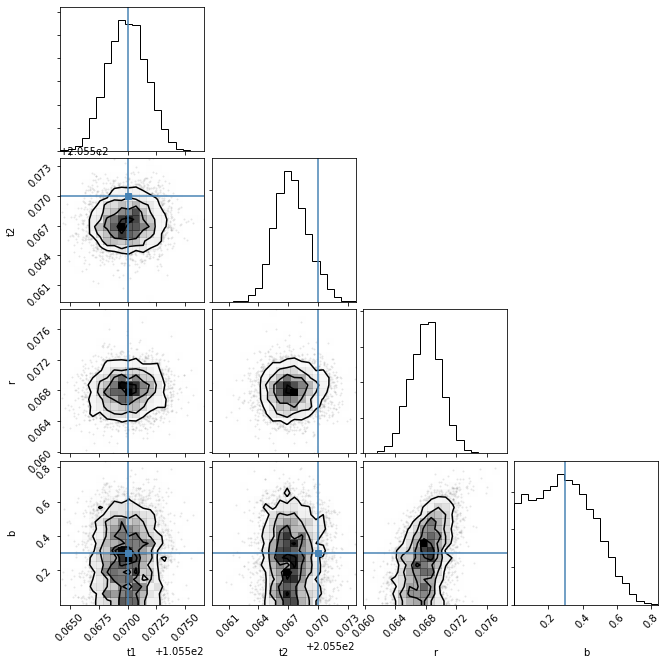

In [39]:
samples = pm.trace_to_dataframe(trace_gp_marg_ecc_newprior, varnames=["t0_1", "t0_2", "r", "b"])
corner.corner(samples, labels=["t1", "t2", "r", "b"], truths=np.concatenate((t0s, [np.sqrt(0.0045), 0.3])));

That looks good (although b is poorly constrained). Maybe I should marginalise over b, as it is likely to also vary given the period?

We have marginalised parameters for each period, with a sample/corner plot possible for each.

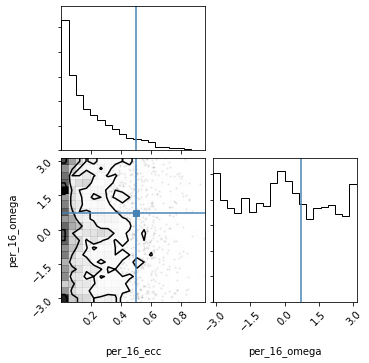

In [45]:
i=16
#Plotting corner for period[i]:
f=corner.corner(pm.trace_to_dataframe(trace_gp_marg_ecc_newprior,varnames=["per_"+str(i)+"_ecc","per_"+str(i)+"_omega"]), 
              labels=["per_"+str(i)+"_ecc","per_"+str(i)+"_omega"],truths=[0.5,0.72])

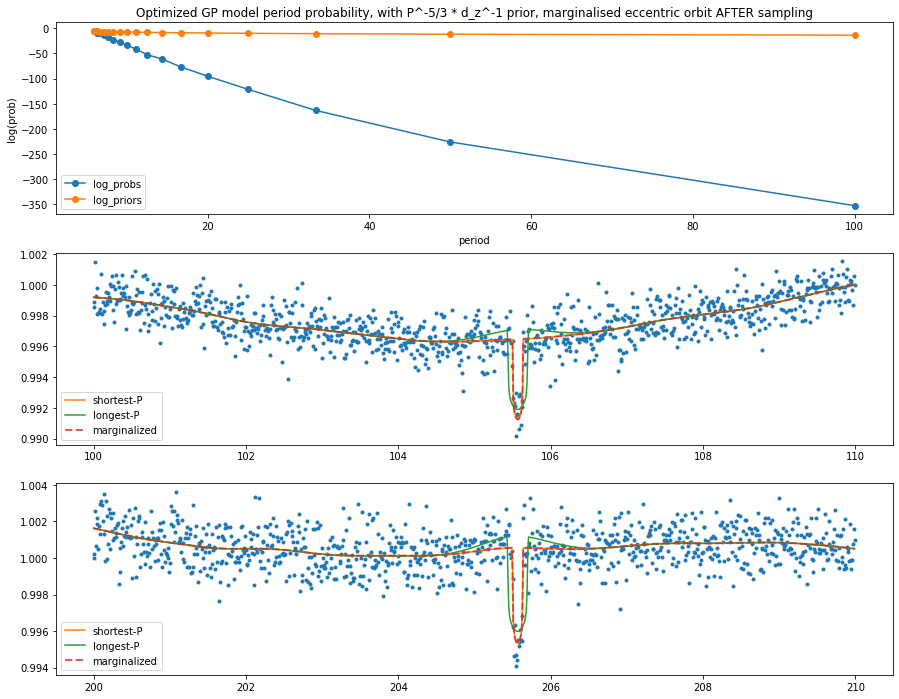

In [41]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(map_soln_gp_marg_ecc_newprior["periods"], np.median(trace_gp_marg_ecc_newprior["logprob_class"],axis=0), "o-",label='log_probs')
plt.xlabel("period")
plt.ylabel("log(prob)")
plt.title("Optimized GP model period probability, with P^-5/3 * d_z^-1 prior, marginalised eccentric orbit AFTER sampling")
plt.plot(map_soln_gp_marg_ecc_newprior["periods"],np.median(trace_gp_marg_ecc_newprior["logprior_class"],axis=0),'-o',label='log_priors')
#[map_soln_gp_marg_ecc['per_'+str(n)+'_log_prior'] for n in range(17)]
plt.legend()

plt.subplot(312)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],np.median(trace_gp_marg_ecc_newprior["per_16_light_curve"],axis=0)[:1000]+np.median(trace_gp_marg_ecc_newprior["per_16_gp_pred"],axis=0)[:1000],label='shortest-P')
plt.plot(x[:1000],np.median(trace_gp_marg_ecc_newprior["per_1_light_curve"],axis=0)[:1000]+np.median(trace_gp_marg_ecc_newprior["per_1_gp_pred"],axis=0)[:1000],label='longest-P')
plt.plot(x[:1000],np.median(trace_gp_marg_ecc_newprior["marginalized_light_curve"],axis=0)[:1000]+np.median(trace_gp_marg_ecc_newprior["marginalized_gp_pred"],axis=0)[:1000],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

plt.subplot(313)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],np.median(trace_gp_marg_ecc_newprior["per_16_light_curve"],axis=0)[1000:]+np.median(trace_gp_marg_ecc_newprior["per_16_gp_pred"],axis=0)[1000:],label='shortest-P')
plt.plot(x[1000:],np.median(trace_gp_marg_ecc_newprior["per_1_light_curve"],axis=0)[1000:]+np.median(trace_gp_marg_ecc_newprior["per_1_gp_pred"],axis=0)[1000:],label='longest-P')
plt.plot(x[1000:],np.median(trace_gp_marg_ecc_newprior["marginalized_light_curve"],axis=0)[1000:]+np.median(trace_gp_marg_ecc_newprior["marginalized_gp_pred"],axis=0)[1000:],'--',alpha=0.75,linewidth=2.0,label='marginalized')
plt.legend()

Ok, after sampling and doing simple medians of the logprobs, that actually seems like it has worked reasonably well - the period matches that from the input!

However, when I do the weighted histogram suggested by Dan, it seems to give the opposite result:

(1e-05, 1)

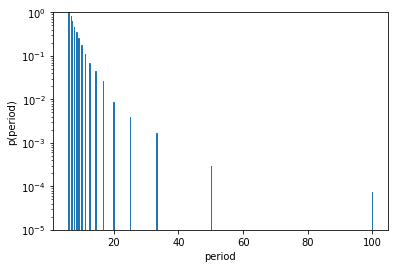

In [42]:
period_samps = trace_gp_marg_ecc_newprior["periods"].flatten()
weight_samps = np.exp(trace_gp_marg_ecc_newprior["logprob_class"].flatten())

plt.hist(period_samps, 500, weights=weight_samps, density=True, histtype="step")
plt.yscale("log")
plt.xlabel("period")
plt.ylabel("p(period)")
plt.ylim(1e-5,1)

In [48]:
trace_gp_marg_ecc_newprior["logprob_class"].shape

(4000, 17)

(0, 500)

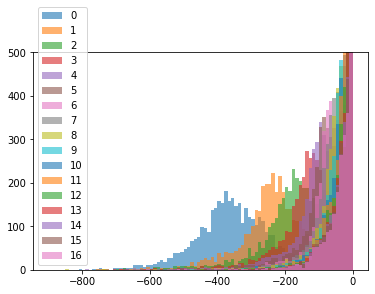

In [162]:
for n in range(17):
    _=plt.hist(trace_gp_marg_ecc_newprior["logprob_class"][:,n],np.arange(-900,0.1,10),alpha=0.6,label=str(n))
#plt.yscale('log')
plt.legend()
plt.ylim(0,500)

(-400, 0)

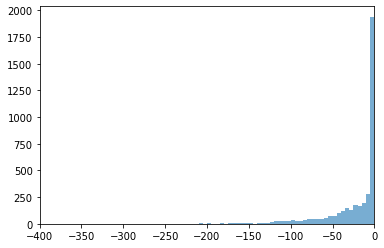

In [213]:
hist_out=plt.hist(trace_gp_marg_ecc_newprior["logprob_class"][:,np.argmax(np.median(trace_gp_marg_ecc_newprior["logprob_class"],axis=0))],np.arange(-900,0.1,5),alpha=0.6)
plt.xlim(-400,0)

In [122]:
np.median(trace_gp_marg_ecc_newprior["logprob_class"],axis=0)

array([-352.26817971, -225.82646795, -163.12885905, -121.33877486,
        -95.35286615,  -76.7064552 ,  -60.7514444 ,  -52.55348191,
        -41.28060019,  -33.63901188,  -27.7787371 ,  -23.06607814,
        -17.413925  ,  -12.99835223,  -10.32050598,   -8.61270079,
         -5.83367122])

In [224]:
# Let's try to match this distribution with inputs from other samples...
bins=np.arange(-899.8,10.2,10)
max_per_ind=np.argmax(np.median(trace_gp_marg_ecc_newprior["logprob_class"],axis=0))
match_hist=np.histogram(trace_gp_marg_ecc_newprior["logprob_class"][:,max_per_ind],bins=bins)[0]
take=[]
for n in range(17):
    if n==np.argmax(np.median(trace_gp_marg_ecc_newprior["logprob_class"],axis=0)):
        take+=[np.tile(True,len(trace_gp_marg_ecc_newprior["logprob_class"][:,n]))]
    else:
        ntake=np.tile(False,len(trace_gp_marg_ecc_newprior["logprob_class"][:,n]))
        nhist=np.histogram(trace_gp_marg_ecc_newprior["logprob_class"][:,n],bins=bins)[0]
        scale=nhist[-1]/match_hist[-1]#scaling by 
        #scale=ratio[])#finding bin with fewest samples w.r.t. to best distribution which we use to match...
        n_to_take_from_bins = np.round(match_hist*scale).astype(int)
        print(n,scale,np.sum(n_to_take_from_bins),np.nanmin(nhist/match_hist))
        digit=np.digitize(trace_gp_marg_ecc_newprior["logprob_class"][:,n],bins)-1
        bin_takes=[]
        for dbin in np.unique(digit):
            #For each bin,taking some number of samples, scaled to the best fit period:
            bin_takes+=[np.arange(len(trace_gp_marg_ecc_newprior["logprob_class"][:,n]))[digit==dbin][np.random.choice(np.sum(digit==dbin),
                                                np.clip(n_to_take_from_bins[dbin],0,int(np.sum(digit==dbin))),
                                                replace=False)]]
        ntake[np.unique(np.hstack(bin_takes))]=True
        take+=[ntake]
take=np.column_stack(take)

0 0.005429864253393665 19 0.005429864253393665
1 0.022171945701357467 86 0.022171945701357467
2 0.041176470588235294 162 0.041176470588235294
3 0.05520361990950226 219 0.05520361990950226
4 0.10407239819004525 415 0.10407239819004525
5 0.1502262443438914 601 0.1502262443438914
6 0.19773755656108596 790 0.0
7 0.23800904977375564 950 0.0
8 0.3217194570135747 1291 0.0
9 0.4081447963800905 1632 0.0
10 0.5009049773755656 2010 0.0
11 0.5728506787330316 2292 0.0
12 0.6864253393665158 2741 0.0
13 0.8126696832579186 3253 0.0
14 0.890497737556561 3563 0.0
15 0.9352941176470588 3745 0.0


In [241]:
newsamples=pd.DataFrame()
for n in range(17):
    tempdf=pm.trace_to_dataframe(trace_gp_marg_ecc_newprior, varnames=["t0_1", "t0_2", "r", "b"]).loc[take[:,n]]
    tempdf['ecc']=trace_gp_marg_ecc_newprior["per_"+str(n)+'_ecc'][take[:,n]]
    tempdf['omega']=trace_gp_marg_ecc_newprior["per_"+str(n)+'_omega'][take[:,n]]
    tempdf['period']=trace_gp_marg_ecc_newprior['periods'][take[:,n],n]
    tempdf['logprobs']=trace_gp_marg_ecc_newprior['logprob_class'][take[:,n],n]
    newsamples=newsamples.append(tempdf)

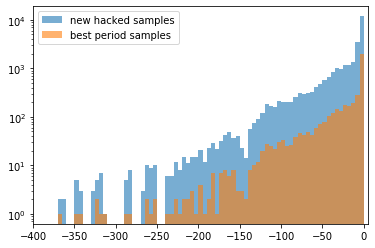

In [248]:
_=plt.hist(newsamples['logprobs'],np.arange(-900,0.1,5),alpha=0.6,label='new hacked samples')
_=plt.hist(trace_gp_marg_ecc_newprior["logprob_class"][:,np.argmax(np.median(trace_gp_marg_ecc_newprior["logprob_class"],axis=0))],np.arange(-900,0.1,5),alpha=0.6,label='best period samples')
plt.legend()
plt.xlim(-400,5)
plt.yscale('log')

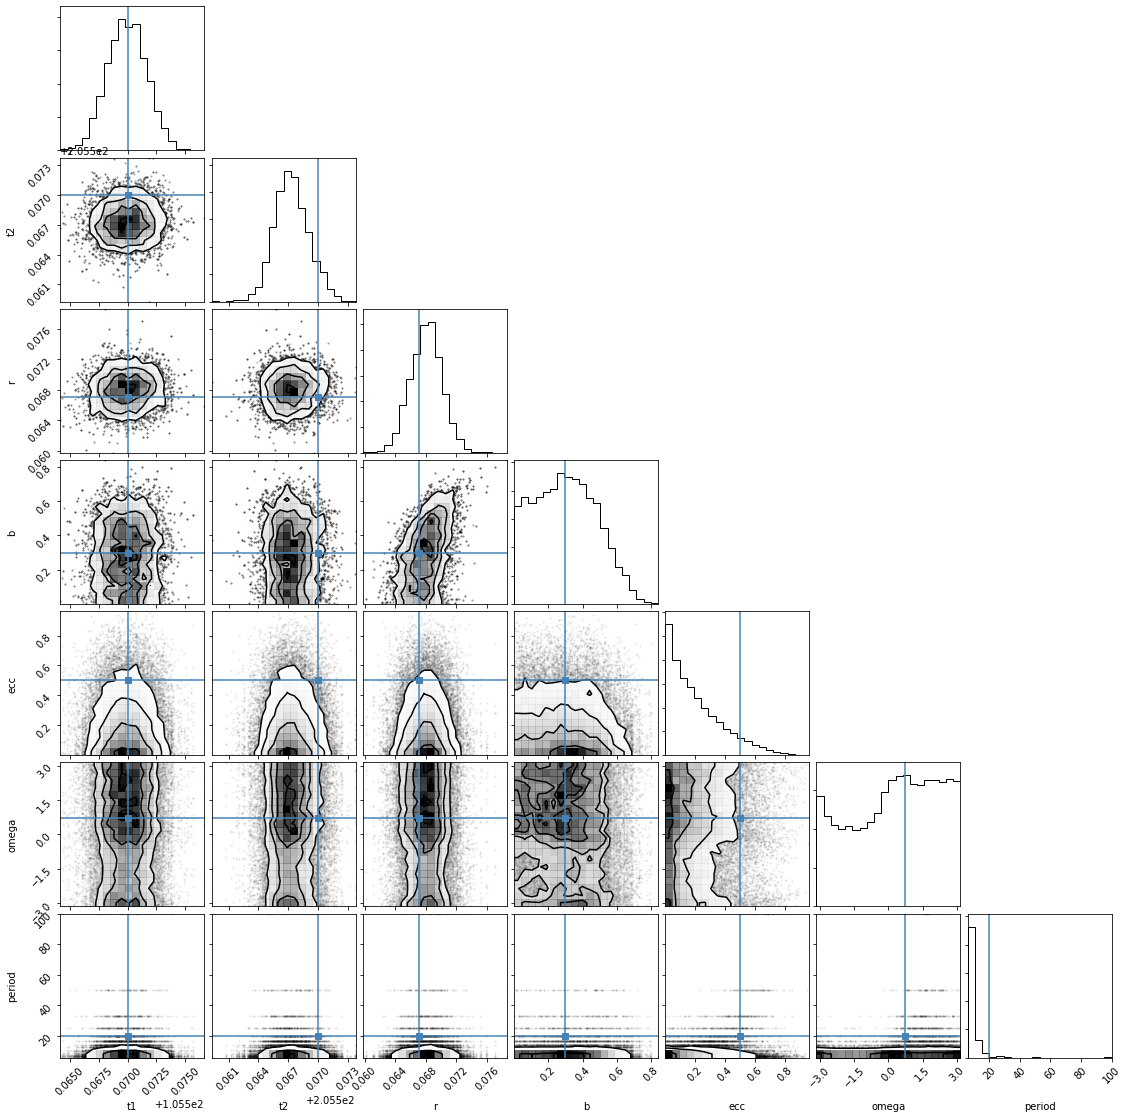

In [240]:
corner.corner(newsamples, labels=["t1", "t2", "r", "b","ecc","omega","period"], truths=np.concatenate((t0s, [np.sqrt(0.0045), 0.3,0.5,0.72,20.0])));


### Putting everything on a corner plot, with ecc, omega & period.

This is a little bit hacky, but let's use the marginalised probability to select samples.

Although, in this case, 99.985\% of samples come from the "correct" period of 50d. Which is crazy! Maybe we should try with more noise.

In [43]:
samples = pm.trace_to_dataframe(trace_gp_marg_ecc_newprior, varnames=["t0_1", "t0_2", "r", "b"])
#Artificially boosting this by a factor 3:
samples = samples.append(pm.trace_to_dataframe(trace_gp_marg_ecc_newprior, varnames=["t0_1", "t0_2", "r", "b"]))
samples = samples.append(pm.trace_to_dataframe(trace_gp_marg_ecc_newprior, varnames=["t0_1", "t0_2", "r", "b"]))

samples['ecc']=np.tile(np.nan,len(samples))
samples['omega']=np.tile(np.nan,len(samples))
samples['period']=np.tile(np.nan,len(samples))



#getting probabilities in form of cumsum:
probs=np.exp(np.median(trace_gp_marg_ecc_newprior["logprob_class"],axis=0))
probs/=np.sum(probs) #normalise to 1
cumprobs=np.hstack((0,np.cumsum(probs)))
sampix=np.arange(len(samples));lensamp=len(trace_gp_marg_ecc_newprior['Rs'])
#Looping through each period and selecting samples:
for n_ci in range(len(cumprobs)-1):
    wh=(sampix>=len(samples)*cumprobs[n_ci])&(sampix<len(samples)*cumprobs[n_ci+1])
    if np.sum(wh)>0:
        #Here we actually have some samples to take:
        samp_ix=np.random.choice(lensamp,np.sum(wh))
        samples.loc[wh,'ecc']=trace_gp_marg_ecc_newprior["per_"+str(n_ci)+'_ecc'][samp_ix]
        samples.loc[wh,'omega']=trace_gp_marg_ecc_newprior["per_"+str(n_ci)+'_omega'][samp_ix]
        samples.loc[wh,'period']=trace_gp_marg_ecc_newprior["periods"][samp_ix,n_ci]


In [47]:
cumprobs

array([0.00000000e+000, 3.26847100e-151, 2.67474470e-096, 4.53427556e-069,
       6.39309075e-051, 1.23380814e-039, 1.54625464e-031, 1.31357300e-024,
       4.77423227e-021, 3.75439431e-016, 7.82424496e-013, 2.75141290e-010,
       3.08244070e-008, 8.73443994e-006, 7.28777693e-004, 1.12080816e-002,
       6.90207222e-002, 1.00000000e+000])

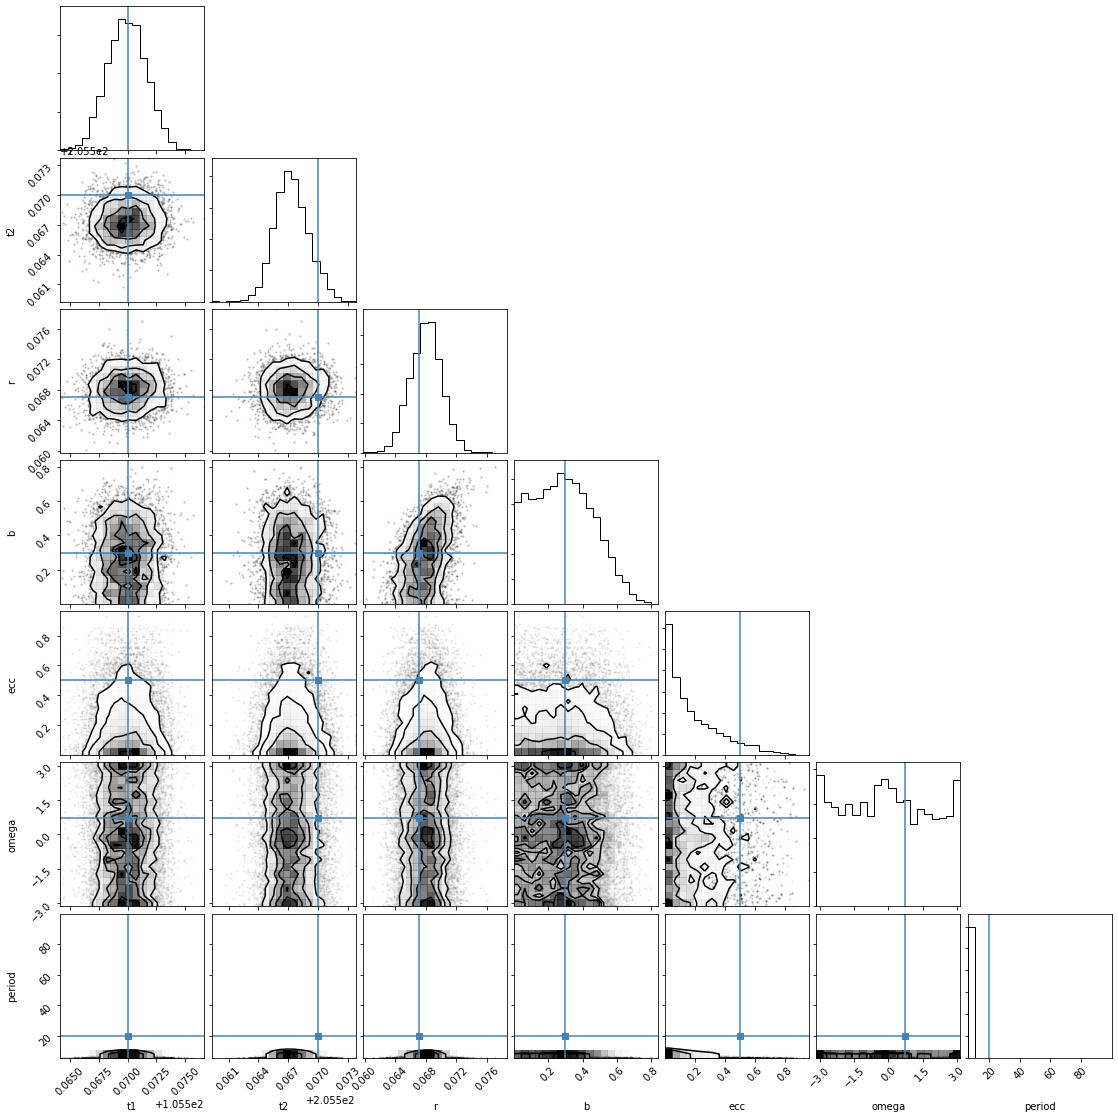

In [46]:
corner.corner(samples, labels=["t1", "t2", "r", "b","ecc","omega","period"], truths=np.concatenate((t0s, [np.sqrt(0.0045), 0.3,0.5,0.72,20.0])));
